In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset

from torchvision.datasets import CIFAR10
import torchvision.transforms as T

from tqdm.notebook import tqdm

import math
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")


cuda


# Residual Block

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, downsample=None, middle_conv_stride=1, residual=True):
        super().__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=middle_conv_stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes, planes*4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes*4) 

        self.relu = nn.ReLU()

        self.downsample = downsample
        self.residual = residual
    
    def forward(self, x):

        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.residual: 
            if self.downsample is not None:
                identity = self.downsample(identity)
            x += identity
        
        x = self.relu(x)
        return x

# ResNet

In [14]:
class ResNet(nn.Module):

    def __init__(self, layer_counts, num_channels=3, num_classes=10, residual=True):
        super().__init__()

        self.layer_counts = layer_counts
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.residual = residual

        self.in_planes = 64
        
        ## Initial Set of Convolution before Residual Blocks
        ## Officially ResNet50 downsamples 224x224 spatial resolution to 32x32 but since we are training on CIFAR10 its already 32x32
        self.conv1 = nn.Conv2d(num_channels, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.Identity() ## Was originally maxpool

        ## Rest of the Model with Residual Blocks
        ## Each layers first Residual Block has to downsample in order to match input and output dimensions for residual connections
        self.layers1 = self._make_layers(layer_counts[0], planes=64, stride=1)
        self.layers2 = self._make_layers(layer_counts[1], planes=128, stride=2)
        self.layers3 = self._make_layers(layer_counts[2], planes=256, stride=2)
        self.layers4 = self._make_layers(layer_counts[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, num_classes)

        #Kaiming He Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        
    def _make_layers(self, num_residual_blocks, planes, stride):
 
        downsample = None
        layers = nn.ModuleList()

        if self.residual:
            if stride != 1 or self.in_planes != planes*4:
                downsample = nn.Sequential(nn.Conv2d(self.in_planes, planes*4, kernel_size=1, stride=stride, bias=False),
                                        nn.BatchNorm2d(planes*4))
            
        layers.append(ResidualBlock(in_planes=self.in_planes,
                                    planes=planes,
                                    downsample=downsample,
                                    middle_conv_stride=stride,
                                    residual=self.residual))
        
        self.in_planes = planes * 4

        for _ in range(num_residual_blocks-1):
            layers.append(ResidualBlock(
                in_planes=self.in_planes,
                planes=planes,
                downsample=None,
                middle_conv_stride=1,
                residual=self.residual
            ))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layers1(x)
        x = self.layers2(x)
        x = self.layers3(x)
        x = self.layers4(x)

        x = torch.flatten(self.avgpool(x), 1)
        x = self.fc(x) 

        return x

def ResNet50(residual=True, num_channels=3, num_classes=10):
    return ResNet(layer_counts=[3,4,6,3],
                num_channels=num_channels,
                num_classes=num_classes,
                residual=residual)

# Dataset Preparation

In [15]:
train_transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    T.RandomErasing(p=0.25)
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

full_train_aug   = CIFAR10('./datasets', train=True, download=True, transform=train_transform)
full_train_clean = CIFAR10('./datasets', train=True, download=True, transform=test_transform)

idx_train, idx_val = random_split(range(len(full_train_aug)), [45000, 5000],
                                  generator=torch.Generator().manual_seed(42))

train_subset = Subset(full_train_aug,   idx_train.indices)
val_subset   = Subset(full_train_clean, idx_val.indices)

test_dataset = CIFAR10('./datasets', train=False,download=True,transform=test_transform)


loader_train = DataLoader(train_subset, batch_size=512, shuffle=True,
                           num_workers=6, pin_memory=True, persistent_workers=True,drop_last=True)

loader_val = DataLoader(val_subset, batch_size=512,shuffle=False,
                        num_workers=6, pin_memory=True, persistent_workers=True)

loader_test = DataLoader(test_dataset, batch_size=512,shuffle=False,
                         num_workers=6, pin_memory=True, persistent_workers=True)

# Training

In [18]:
def train(model, device, epochs, optimizer, loss_fn, trainloader, valloader, scheduler=None):
    log_training = {"epoch": [],
                    "training_loss": [],
                    "training_acc": [],
                    "validation_loss": [],
                    "validation_acc": []}

    for epoch in range(1, epochs + 1):
        print(f"Starting Epoch {epoch}")
        train_loss_sum, train_correct, train_total = 0.0, 0, 0
        
        model.train()
        for image, label in tqdm(trainloader):
            image, label = image.to(device=device,memory_format=torch.channels_last), label.to(device)
            for param in model.parameters():
                param.grad = None
            with torch.autocast(device_type=device,dtype=torch.bfloat16):
                out = model(image)
                loss = loss_fn(out, label)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            batch_size = label.size(0)
            train_loss_sum += loss.item() * batch_size
            preds = torch.argmax(out, dim=1)
            train_correct += (preds == label).sum().item()
            train_total   += batch_size

        training_loss_mean = train_loss_sum / train_total
        training_acc_mean  = train_correct  / train_total

        model.eval()

        val_loss_sum, val_correct, val_total = 0.0, 0, 0
        
        for image, label in tqdm(valloader):
            image, label = image.to(device=device,memory_format=torch.channels_last), label.to(device)

        with torch.inference_mode():
            with torch.autocast(device_type=device,dtype=torch.bfloat16):
                out = model(image)
                loss = loss_fn(out, label)

            batch_size = label.size(0)
            val_loss_sum += loss.item() * batch_size
            preds = torch.argmax(out, dim=1)
            val_correct += (preds == label).sum().item()
            val_total   += batch_size

        valid_loss_mean = val_loss_sum / val_total
        valid_acc_mean  = val_correct  / val_total

        log_training["epoch"].append(epoch)
        log_training["training_loss"].append(training_loss_mean)
        log_training["training_acc"].append(training_acc_mean)
        log_training["validation_loss"].append(valid_loss_mean)
        log_training["validation_acc"].append(valid_acc_mean)

        print("Training Loss:", training_loss_mean) 
        print("Training Acc:", training_acc_mean)
        print("Validation Loss:", valid_loss_mean)
        print("Validation Acc:", valid_acc_mean)

        if scheduler is not None:
            scheduler.step()
        
    return log_training, model

In [19]:
epochs = 100
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

model = ResNet50().to(device)
model = model.to(memory_format=torch.channels_last)
model = torch.compile(model)
optimizer = optim.SGD(model.parameters(),
                      lr=0.3,           
                      momentum=0.9,     
                      nesterov=True,    
                      weight_decay=1e-4 
                     )

warmup_epochs = 10
main_epochs   = epochs - warmup_epochs

sched_warm = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=1/warmup_epochs, total_iters=warmup_epochs
)
sched_main = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=main_epochs
)
scheduler  = torch.optim.lr_scheduler.SequentialLR(
    optimizer, [sched_warm, sched_main], milestones=[warmup_epochs]
)

log_training, model = train(model=model,
                            device=device,
                            epochs=epochs,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            trainloader=loader_train,
                            valloader=loader_val,
                            scheduler=scheduler)

Starting Epoch 1


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 2.2412577442739203
Training Acc: 0.15928071120689655
Validation Loss: 2.1807873249053955
Validation Acc: 0.18622448979591838
Starting Epoch 2


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 2.1417568976851715
Training Acc: 0.22249910201149425
Validation Loss: 2.0786681175231934
Validation Acc: 0.25255102040816324
Starting Epoch 3


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 2.185588451637619
Training Acc: 0.26171875
Validation Loss: 2.0345284938812256
Validation Acc: 0.3163265306122449
Starting Epoch 4


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 1.986925721168518
Training Acc: 0.3462419181034483
Validation Loss: 2.542757034301758
Validation Acc: 0.34438775510204084
Starting Epoch 5


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 1.7067810666972194
Training Acc: 0.44517780172413796
Validation Loss: 4.328906059265137
Validation Acc: 0.4719387755102041
Starting Epoch 6


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 1.527459594025009
Training Acc: 0.5372440732758621
Validation Loss: 1.5902565717697144
Validation Acc: 0.5331632653061225
Starting Epoch 7


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 1.3519698956917072
Training Acc: 0.6178609913793104
Validation Loss: 1.356844425201416
Validation Acc: 0.6607142857142857
Starting Epoch 8


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 1.2025664277460384
Training Acc: 0.6894755747126436
Validation Loss: 1.2743394374847412
Validation Acc: 0.6658163265306123
Starting Epoch 9


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 1.0885446071624756
Training Acc: 0.7411772629310345
Validation Loss: 1.1983306407928467
Validation Acc: 0.6989795918367347
Starting Epoch 10


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 1.000776226493134
Training Acc: 0.7809581537356322
Validation Loss: 1.0777729749679565
Validation Acc: 0.7525510204081632
Starting Epoch 11


c:\Users\kriyu\miniconda3\envs\generalPython\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.9814616633557726
Training Acc: 0.7973913433908046
Validation Loss: 0.9865865707397461
Validation Acc: 0.8061224489795918
Starting Epoch 12


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.9147837223677799
Training Acc: 0.8219737787356322
Validation Loss: 1.0479403734207153
Validation Acc: 0.7729591836734694
Starting Epoch 13


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8717759135125698
Training Acc: 0.8404049928160919
Validation Loss: 0.9149655699729919
Validation Acc: 0.8316326530612245
Starting Epoch 14


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.838352172539152
Training Acc: 0.8537401221264368
Validation Loss: 0.9009362459182739
Validation Acc: 0.8341836734693877
Starting Epoch 15


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8234796517196743
Training Acc: 0.8601607399425287
Validation Loss: 0.8832485675811768
Validation Acc: 0.8469387755102041
Starting Epoch 16


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.799662431766247
Training Acc: 0.8698141163793104
Validation Loss: 0.9306328296661377
Validation Acc: 0.8214285714285714
Starting Epoch 17


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.7797122892292067
Training Acc: 0.8788613505747126
Validation Loss: 0.7846686840057373
Validation Acc: 0.8775510204081632
Starting Epoch 18


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.7660029338694166
Training Acc: 0.8844962284482759
Validation Loss: 0.8278083801269531
Validation Acc: 0.8724489795918368
Starting Epoch 19


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.757315646642926
Training Acc: 0.8888290229885057
Validation Loss: 0.7894104719161987
Validation Acc: 0.875
Starting Epoch 20


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.7429768525320908
Training Acc: 0.8955414870689655
Validation Loss: 0.8370025157928467
Validation Acc: 0.8443877551020408
Starting Epoch 21


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.7294422463438976
Training Acc: 0.9009967672413793
Validation Loss: 0.8135733604431152
Validation Acc: 0.8494897959183674
Starting Epoch 22


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.7249992715901342
Training Acc: 0.9025457974137931
Validation Loss: 0.8421124219894409
Validation Acc: 0.8520408163265306
Starting Epoch 23


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.7182944691044161
Training Acc: 0.9080010775862069
Validation Loss: 0.8453286290168762
Validation Acc: 0.8673469387755102
Starting Epoch 24


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.7029063886609571
Training Acc: 0.9120195761494253
Validation Loss: 0.8328992128372192
Validation Acc: 0.8520408163265306
Starting Epoch 25


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6944456744468075
Training Acc: 0.9148706896551724
Validation Loss: 0.8062753081321716
Validation Acc: 0.8698979591836735
Starting Epoch 26


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6886750843333102
Training Acc: 0.9201014727011494
Validation Loss: 1.058626651763916
Validation Acc: 0.7933673469387755
Starting Epoch 27


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.688368319779977
Training Acc: 0.9178340517241379
Validation Loss: 0.8037075996398926
Validation Acc: 0.8826530612244898
Starting Epoch 28


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6802470156516152
Training Acc: 0.9221219468390804
Validation Loss: 0.8707922697067261
Validation Acc: 0.8494897959183674
Starting Epoch 29


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6758686071154715
Training Acc: 0.923828125
Validation Loss: 0.8237013816833496
Validation Acc: 0.8724489795918368
Starting Epoch 30


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.670929978633749
Training Acc: 0.92578125
Validation Loss: 0.7874484062194824
Validation Acc: 0.8852040816326531
Starting Epoch 31


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6617535188280302
Training Acc: 0.9289017600574713
Validation Loss: 0.8785022497177124
Validation Acc: 0.8367346938775511
Starting Epoch 32


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6582281932063486
Training Acc: 0.9311018318965517
Validation Loss: 0.8449694514274597
Validation Acc: 0.8571428571428571
Starting Epoch 33


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6508117694964354
Training Acc: 0.9343570402298851
Validation Loss: 0.810666561126709
Validation Acc: 0.875
Starting Epoch 34


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6483016938998781
Training Acc: 0.9366693606321839
Validation Loss: 0.7491625547409058
Validation Acc: 0.8979591836734694
Starting Epoch 35


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6512581801962578
Training Acc: 0.9336161997126436
Validation Loss: 0.6830835938453674
Validation Acc: 0.9285714285714286
Starting Epoch 36


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6392203309070105
Training Acc: 0.940081716954023
Validation Loss: 0.8441265821456909
Validation Acc: 0.875
Starting Epoch 37


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6393837723238714
Training Acc: 0.9389143318965517
Validation Loss: 0.8156943321228027
Validation Acc: 0.8571428571428571
Starting Epoch 38


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6314653247252278
Training Acc: 0.9434940732758621
Validation Loss: 0.8010877370834351
Validation Acc: 0.8852040816326531
Starting Epoch 39


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.630863558286908
Training Acc: 0.943426724137931
Validation Loss: 0.8668715953826904
Validation Acc: 0.8418367346938775
Starting Epoch 40


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6265118670189518
Training Acc: 0.944683908045977
Validation Loss: 0.7174173593521118
Validation Acc: 0.9132653061224489
Starting Epoch 41


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6213023566651619
Training Acc: 0.9467941810344828
Validation Loss: 0.7379956841468811
Validation Acc: 0.9107142857142857
Starting Epoch 42


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6194115637362688
Training Acc: 0.9486350574712644
Validation Loss: 0.719008207321167
Validation Acc: 0.9056122448979592
Starting Epoch 43


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6151399598724541
Training Acc: 0.9502738864942529
Validation Loss: 0.6904151439666748
Validation Acc: 0.9311224489795918
Starting Epoch 44


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6121198192410086
Training Acc: 0.9510371767241379
Validation Loss: 0.6939915418624878
Validation Acc: 0.9209183673469388
Starting Epoch 45


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6113748612075016
Training Acc: 0.9510820761494253
Validation Loss: 0.8170843124389648
Validation Acc: 0.8903061224489796
Starting Epoch 46


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6054391018275557
Training Acc: 0.9547638290229885
Validation Loss: 0.6887811422348022
Validation Acc: 0.9056122448979592
Starting Epoch 47


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6017568001801941
Training Acc: 0.9557965158045977
Validation Loss: 0.6862270832061768
Validation Acc: 0.9362244897959183
Starting Epoch 48


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6001317754559133
Training Acc: 0.9568516522988506
Validation Loss: 0.7327227592468262
Validation Acc: 0.9056122448979592
Starting Epoch 49


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5984385116346951
Training Acc: 0.9566945043103449
Validation Loss: 0.7466782331466675
Validation Acc: 0.9030612244897959
Starting Epoch 50


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5925433512391716
Training Acc: 0.9600395114942529
Validation Loss: 0.7487977743148804
Validation Acc: 0.9056122448979592
Starting Epoch 51


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5912290626558764
Training Acc: 0.9604211566091954
Validation Loss: 0.7206922769546509
Validation Acc: 0.9158163265306123
Starting Epoch 52


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5903218731112864
Training Acc: 0.9608252514367817
Validation Loss: 0.7350640892982483
Validation Acc: 0.9005102040816326
Starting Epoch 53


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5830075843580838
Training Acc: 0.9645070043103449
Validation Loss: 0.735504150390625
Validation Acc: 0.8979591836734694
Starting Epoch 54


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5842262876444849
Training Acc: 0.9637212643678161
Validation Loss: 0.7447772026062012
Validation Acc: 0.9158163265306123
Starting Epoch 55


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5780729233533487
Training Acc: 0.9664601293103449
Validation Loss: 0.7017987966537476
Validation Acc: 0.9081632653061225
Starting Epoch 56


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5769824645985132
Training Acc: 0.9663703304597702
Validation Loss: 0.7470731735229492
Validation Acc: 0.9030612244897959
Starting Epoch 57


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5739937650746313
Training Acc: 0.968054058908046
Validation Loss: 0.7475471496582031
Validation Acc: 0.8979591836734694
Starting Epoch 58


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.571143071541841
Training Acc: 0.9698949353448276
Validation Loss: 0.6584799289703369
Validation Acc: 0.9311224489795918
Starting Epoch 59


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5699597809506559
Training Acc: 0.9707255747126436
Validation Loss: 0.757319986820221
Validation Acc: 0.9107142857142857
Starting Epoch 60


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5667914816702919
Training Acc: 0.9710847701149425
Validation Loss: 0.6550154685974121
Validation Acc: 0.9311224489795918
Starting Epoch 61


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5634550143932474
Training Acc: 0.9729705459770115
Validation Loss: 0.6873842477798462
Validation Acc: 0.9209183673469388
Starting Epoch 62


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5601417326379097
Training Acc: 0.9739583333333334
Validation Loss: 0.6480587124824524
Validation Acc: 0.9438775510204082
Starting Epoch 63


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5573318210141412
Training Acc: 0.9753951149425287
Validation Loss: 0.6601524353027344
Validation Acc: 0.9464285714285714
Starting Epoch 64


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.554943201185643
Training Acc: 0.9763604525862069
Validation Loss: 0.6528406143188477
Validation Acc: 0.9464285714285714
Starting Epoch 65


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5562085194149237
Training Acc: 0.9751706178160919
Validation Loss: 0.6921848058700562
Validation Acc: 0.9183673469387755
Starting Epoch 66


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5517110180580753
Training Acc: 0.9781115301724138
Validation Loss: 0.6906301975250244
Validation Acc: 0.9285714285714286
Starting Epoch 67


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5512214207101143
Training Acc: 0.9783360272988506
Validation Loss: 0.6317164301872253
Validation Acc: 0.9540816326530612
Starting Epoch 68


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5435133747670843
Training Acc: 0.9816810344827587
Validation Loss: 0.6523537635803223
Validation Acc: 0.9336734693877551
Starting Epoch 69


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5435535297996696
Training Acc: 0.9810299928160919
Validation Loss: 0.6788208484649658
Validation Acc: 0.9362244897959183
Starting Epoch 70


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.542888309078655
Training Acc: 0.9815687859195402
Validation Loss: 0.6798408627510071
Validation Acc: 0.9260204081632653
Starting Epoch 71


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5402470326971733
Training Acc: 0.9827361709770115
Validation Loss: 0.6682957410812378
Validation Acc: 0.9413265306122449
Starting Epoch 72


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5403455098470052
Training Acc: 0.9827361709770115
Validation Loss: 0.6149193048477173
Validation Acc: 0.951530612244898
Starting Epoch 73


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5380915663708216
Training Acc: 0.9841056034482759
Validation Loss: 0.636215090751648
Validation Acc: 0.951530612244898
Starting Epoch 74


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5342202837439789
Training Acc: 0.985699533045977
Validation Loss: 0.6720665097236633
Validation Acc: 0.9285714285714286
Starting Epoch 75


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5341796100824728
Training Acc: 0.9858117816091954
Validation Loss: 0.6494899988174438
Validation Acc: 0.9489795918367347
Starting Epoch 76


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5318327148755392
Training Acc: 0.9867097701149425
Validation Loss: 0.6505295038223267
Validation Acc: 0.9540816326530612
Starting Epoch 77


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5319569597299072
Training Acc: 0.9866199712643678
Validation Loss: 0.620846152305603
Validation Acc: 0.9540816326530612
Starting Epoch 78


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5302992997498348
Training Acc: 0.9870689655172413
Validation Loss: 0.6557831168174744
Validation Acc: 0.9438775510204082
Starting Epoch 79


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5275159348016498
Training Acc: 0.9887751436781609
Validation Loss: 0.6464686989784241
Validation Acc: 0.9464285714285714
Starting Epoch 80


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5257050888291721
Training Acc: 0.9893139367816092
Validation Loss: 0.6241777539253235
Validation Acc: 0.9591836734693877
Starting Epoch 81


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5264176527659098
Training Acc: 0.9890445402298851
Validation Loss: 0.6337006092071533
Validation Acc: 0.9540816326530612
Starting Epoch 82


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.525392994798463
Training Acc: 0.9891118893678161
Validation Loss: 0.6412839889526367
Validation Acc: 0.9489795918367347
Starting Epoch 83


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5246922819093726
Training Acc: 0.9896506824712644
Validation Loss: 0.6266953945159912
Validation Acc: 0.9540816326530612
Starting Epoch 84


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5225915792344631
Training Acc: 0.9902792744252874
Validation Loss: 0.6362426280975342
Validation Acc: 0.951530612244898
Starting Epoch 85


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5229040603528078
Training Acc: 0.9902792744252874
Validation Loss: 0.6504558324813843
Validation Acc: 0.9489795918367347
Starting Epoch 86


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5225734237966866
Training Acc: 0.9905037715517241
Validation Loss: 0.6509787440299988
Validation Acc: 0.951530612244898
Starting Epoch 87


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5205965391520796
Training Acc: 0.9913793103448276
Validation Loss: 0.6368168592453003
Validation Acc: 0.951530612244898
Starting Epoch 88


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5198779976230928
Training Acc: 0.9914466594827587
Validation Loss: 0.6384314298629761
Validation Acc: 0.9464285714285714
Starting Epoch 89


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5202300267658014
Training Acc: 0.9912446120689655
Validation Loss: 0.6371932029724121
Validation Acc: 0.9438775510204082
Starting Epoch 90


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5206880357073641
Training Acc: 0.9909527658045977
Validation Loss: 0.6305122971534729
Validation Acc: 0.9591836734693877
Starting Epoch 91


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5196331801085636
Training Acc: 0.991491558908046
Validation Loss: 0.6301230788230896
Validation Acc: 0.9566326530612245
Starting Epoch 92


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.518914243270611
Training Acc: 0.9920977011494253
Validation Loss: 0.6265820860862732
Validation Acc: 0.9591836734693877
Starting Epoch 93


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.518479093052875
Training Acc: 0.9921426005747126
Validation Loss: 0.628807008266449
Validation Acc: 0.9566326530612245
Starting Epoch 94


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5190744591855455
Training Acc: 0.9920079022988506
Validation Loss: 0.6254115104675293
Validation Acc: 0.951530612244898
Starting Epoch 95


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5167663487894781
Training Acc: 0.9930854885057471
Validation Loss: 0.6303077340126038
Validation Acc: 0.9540816326530612
Starting Epoch 96


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5181198976505762
Training Acc: 0.9924119971264368
Validation Loss: 0.6255079507827759
Validation Acc: 0.9540816326530612
Starting Epoch 97


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5197600044053177
Training Acc: 0.9912446120689655
Validation Loss: 0.6253477334976196
Validation Acc: 0.9540816326530612
Starting Epoch 98


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5197352102433128
Training Acc: 0.9916711566091954
Validation Loss: 0.6285939812660217
Validation Acc: 0.9566326530612245
Starting Epoch 99


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5187599967265951
Training Acc: 0.9916487068965517
Validation Loss: 0.6269427537918091
Validation Acc: 0.9591836734693877
Starting Epoch 100


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.5177227971197544
Training Acc: 0.9921875
Validation Loss: 0.6236976981163025
Validation Acc: 0.9566326530612245


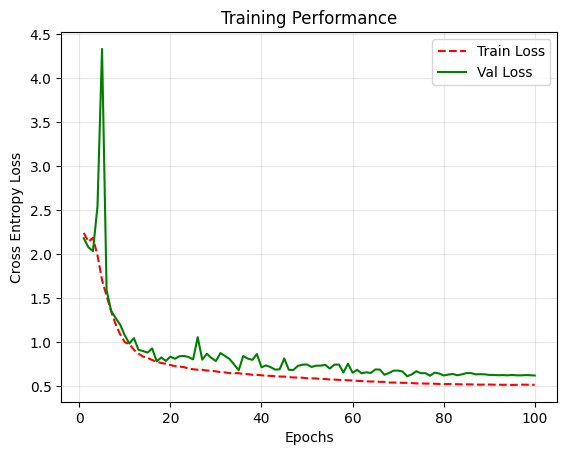

In [20]:
plt.figure()
plt.plot(log_training["epoch"], log_training["training_loss"],  "r--", label="Train Loss")
plt.plot(log_training["epoch"], log_training["validation_loss"], "g-",  label="Val Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Performance")
plt.grid(True, alpha=0.3)
plt.savefig("training_curves.png", dpi=200, bbox_inches="tight")
plt.show()

In [21]:
@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = model(images)
        loss = loss_fn(logits, labels)

        bs = labels.size(0)
        loss_sum += loss.item() * bs
        correct  += (logits.argmax(1) == labels).sum().item()
        total    += bs

    return loss_sum / total, correct / total

test_loss_fn = nn.CrossEntropyLoss()

test_loss, test_acc = evaluate(model, loader_test, test_loss_fn, device)
print(f"TEST  loss={test_loss:.4f}  acc={test_acc:.4%}")

TEST  loss=0.2533  acc=94.8200%


# Showing 10 Missclassified Samples in the Test Set

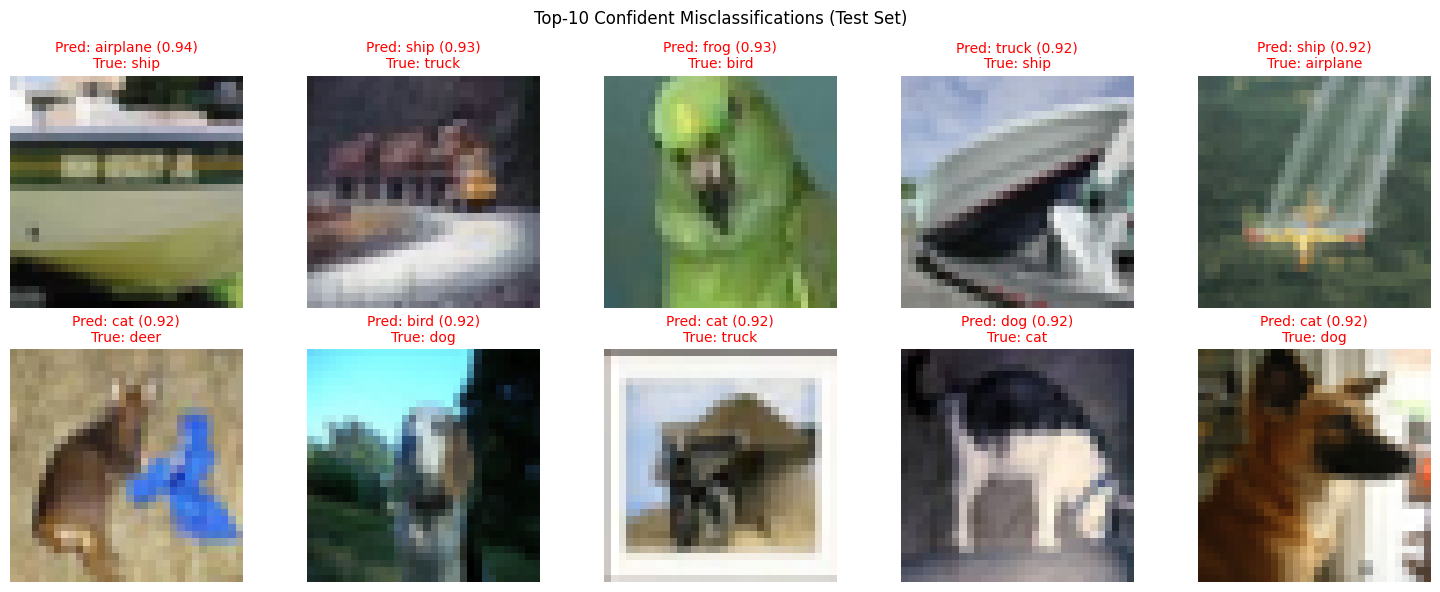

Found 518 misclassified samples in the test set.


In [ ]:
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
std  = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1)

def denorm(img):
    return (img * std + mean).clamp(0, 1)

def get_classes(ds):
    while hasattr(ds, "dataset"):
        ds = ds.dataset
    return getattr(ds, "classes", [str(i) for i in range(10)])

classes = get_classes(loader_test.dataset)

misclassified = []  

model.eval()
with torch.no_grad():
    for images, labels in loader_test:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = model(images)
        probs = torch.softmax(logits, dim=1)
        conf, preds = probs.max(dim=1)

        wrong_mask = preds.ne(labels)
        wrong_idx = torch.nonzero(wrong_mask, as_tuple=False).squeeze(1)

        for i in wrong_idx.tolist():
            misclassified.append((
                images[i].cpu(),         
                int(labels[i].item()),   
                int(preds[i].item()),    
                float(conf[i].item())    
            ))

misclassified.sort(key=lambda x: x[3], reverse=True)

k = min(10, len(misclassified))
rows, cols = 2, 5
plt.figure(figsize=(cols*3, rows*3))
for idx in range(k):
    img_t, y_true, y_pred, c = misclassified[idx]
    img_np = denorm(img_t).permute(1, 2, 0).numpy()

    ax = plt.subplot(rows, cols, idx+1)
    ax.imshow(img_np)
    ax.axis("off")
    ax.set_title(f"Pred: {classes[y_pred]} ({c:.2f})\nTrue: {classes[y_true]}", color="red", fontsize=10)

plt.suptitle("Top-10 Confident Misclassifications (Test Set)", fontsize=12)
plt.tight_layout()
plt.savefig("misclassified_examples.png", dpi=200, bbox_inches="tight")
plt.show()

print(f"Found {len(misclassified)} misclassified samples in the test set.")